# Compare erosion rates and vegetation lines
This files uses the output from DSAS. It visualises and sumarises the erosion rates and distance calculations for Bull Island in 2017, 2019 and 2021.  

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd

import os
import glob

data_path = "/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/data"
figure_path = "/Users/conorosullivan/Google Drive/My Drive/1 UCD/0 research/JP02 - Vegetation Line/figures"

# IBM colour blind palette
blue = "#648fff" #2017
orange = "#fe6100" #2019
red = "#dc267f" #2021
purple = "#785EF0" #overall

## Step 1: process all rates


In [6]:
# Loads transects
transect_path = os.path.join(data_path, "processed/dsas_files/COM_2021_transects_20250908_102419.geojson")
transect = gpd.read_file(transect_path)
transect.rename(columns={"ObjectID": "TransectId"}, inplace=True)

# Create base table
trasect_base = transect[['TransectId']]


print(len(trasect_base), "transects found")
trasect_base.head()

187 transects found


,TransectId
0,1
1,2
2,3
3,4
4,5


In [14]:
# Erosion rates calcualted using ADVLs
advl_paths = glob.glob(os.path.join(data_path, "processed/dsas_files/ADVL*rates*.geojson"))
advl_paths.sort()
print(len(advl_paths), "ADVL rate files found")

# Erosion rates calcualted using MAVLs
mavl_paths = glob.glob(os.path.join(data_path, "processed/dsas_files/MAVL*rates*.geojson"))
mavl_paths.sort()
print(len(mavl_paths), "MAVL rate files found")

rate_paths = advl_paths + mavl_paths

# Distances comparision between ADVLs and MAVLs
distance_paths = glob.glob(os.path.join(data_path, "processed/dsas_files/COM*rates*.geojson"))
distance_paths.sort()
print(len(distance_paths), "COM rate files found")

3 ADVL rate files found
3 MAVL rate files found
3 COM rate files found


In [17]:
def get_rates(metric, rate_paths,trasect_base):

    """Format dsas rates into a single table"""

    rates = trasect_base.copy()

    for rate_path in rate_paths:

        file_name = os.path.basename(rate_path)

        rate_id = file_name[:14]
        if "COM" in rate_id:
            rate_id = file_name.split("_")[1] #only use year for distance files
        print(f"Processing {rate_id}")

        period_rates = gpd.read_file(rate_path)
        period_rates = period_rates[['TransectId',metric]]
        period_rates.rename(columns={metric: rate_id}, inplace=True)

        # Left Join rates to transect
        rates = rates.merge(period_rates, on="TransectId", how="left")

    return rates


In [19]:
# Erosion rates
epr_erosion_rates = get_rates("EPR", rate_paths, trasect_base)
epr_erosion_rates.to_csv(os.path.join(data_path, f"results/erosion_rates_EPR.csv"), index=False)
epr_erosion_rates.head()

Processing ADVL_2017_2019
Processing ADVL_2017_2021
Processing ADVL_2019_2021
Processing MAVL_2017_2019
Processing MAVL_2017_2021
Processing MAVL_2019_2021


,TransectId,ADVL_2017_2019,ADVL_2017_2021,ADVL_2019_2021,MAVL_2017_2019,MAVL_2017_2021,MAVL_2019_2021
0,1,2.70,2.02,1.30,3.58,2.82,2.01
1,2,2.41,1.65,0.85,4.23,3.20,2.11
2,3,3.38,2.16,0.86,8.84,5.49,1.94
3,4,4.73,2.87,0.90,6.09,2.80,-0.68
4,5,5.20,3.20,1.08,6.65,3.22,-0.41


In [20]:
# Erosion rates
NSM_distances = get_rates("NSM", distance_paths, trasect_base)
NSM_distances.to_csv(os.path.join(data_path, f"results/vl_distances_NSM.csv"), index=False)
NSM_distances.head()

Processing 2017
Processing 2019
Processing 2021


,TransectId,2017,2019,2021
0,1,0.22,-1.55,-2.88
1,2,0.54,-3.11,-5.48
2,3,9.26,-1.66,-3.70
3,4,-0.33,-3.05,-0.07
4,5,0.28,-2.60,0.20


## Step 2: Compare erosion rates

In [22]:
rates = pd.read_csv(os.path.join(data_path, f"results/erosion_rates_EPR.csv"))

In [25]:
# Calculate correlation coefficient and exclude nan
rates_2017_2021 = rates[['ADVL_2017_2021', 'MAVL_2017_2021']].dropna()
corr_2017_2021 = np.corrcoef(rates_2017_2021['ADVL_2017_2021'], rates_2017_2021['MAVL_2017_2021'])[0, 1]
print("Correlation coefficient (2017-2021):", corr_2017_2021.round(2))

rates_2017_2019 = rates[['ADVL_2017_2019', 'MAVL_2017_2019']].dropna()
corr_2017_2019 = np.corrcoef(rates_2017_2019['ADVL_2017_2019'], rates_2017_2019['MAVL_2017_2019'])[0, 1]
print("Correlation coefficient (2017-2019):", corr_2017_2019.round(2))

rates_2019_2021 = rates[['ADVL_2019_2021', 'MAVL_2019_2021']].dropna()
corr_2019_2021 = np.corrcoef(rates_2019_2021['ADVL_2019_2021'], rates_2019_2021['MAVL_2019_2021'])[0, 1]
print("Correlation coefficient (2019-2021):", corr_2019_2021.round(2))

Correlation coefficient (2017-2021): 0.97
Correlation coefficient (2017-2019): 0.9
Correlation coefficient (2019-2021): 0.93


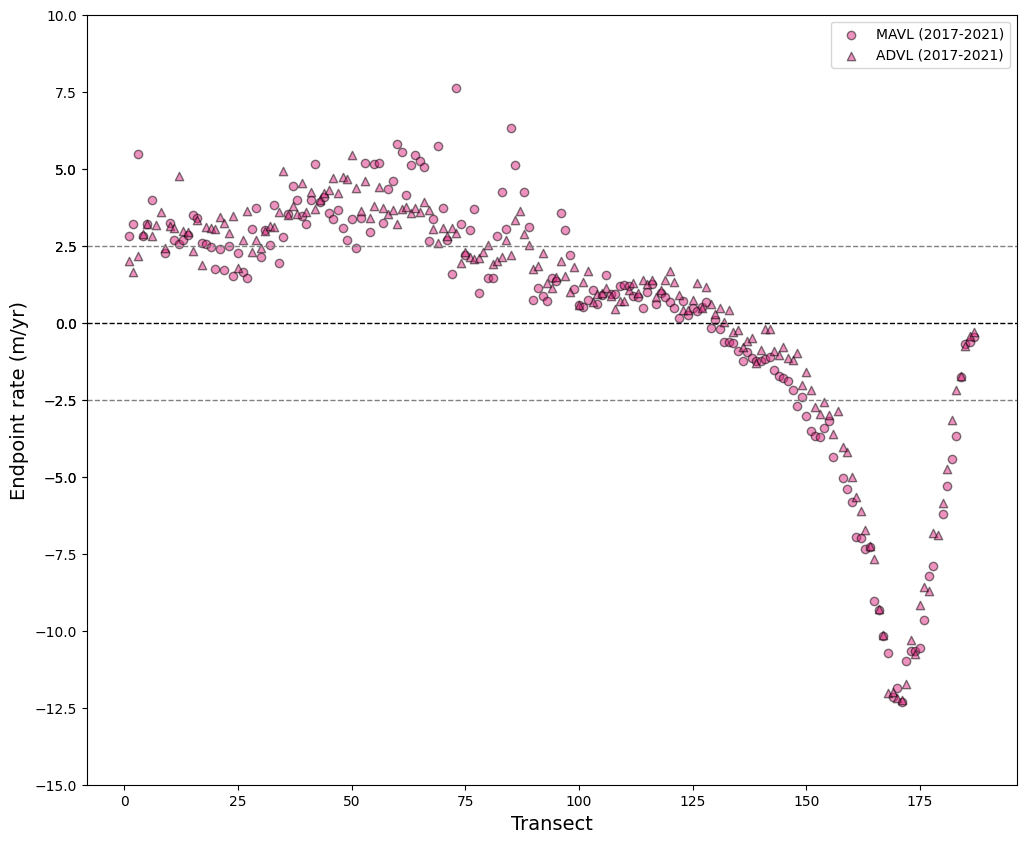

In [26]:
plt.figure(figsize=(12, 10))

plt.scatter(rates['TransectId'], rates['MAVL_2017_2021'], label='MAVL (2017-2021)', marker='o',color=red,edgecolor='black',alpha=0.5)
plt.scatter(rates['TransectId'], rates['ADVL_2017_2021'], label='ADVL (2017-2021)', marker='^',facecolor=red,edgecolor='black',alpha=0.5)

#add verticle line at 0 
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(-2.5, color='grey', linestyle='--', linewidth=1)
plt.axhline(2.5, color='grey', linestyle='--', linewidth=1)

plt.xlabel('Transect',size=14)
plt.ylabel('Endpoint rate (m/yr)',size=14)
plt.legend()

# add y-ticks at [-5, -2.5, 0, 2.5, 5] in additional to all existing ticks
plt.yticks(list(plt.yticks()[0]) + [-5, -2.5, 0, 2.5, 5])

save_path = os.path.join(figure_path, "epr_comparison_4years.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

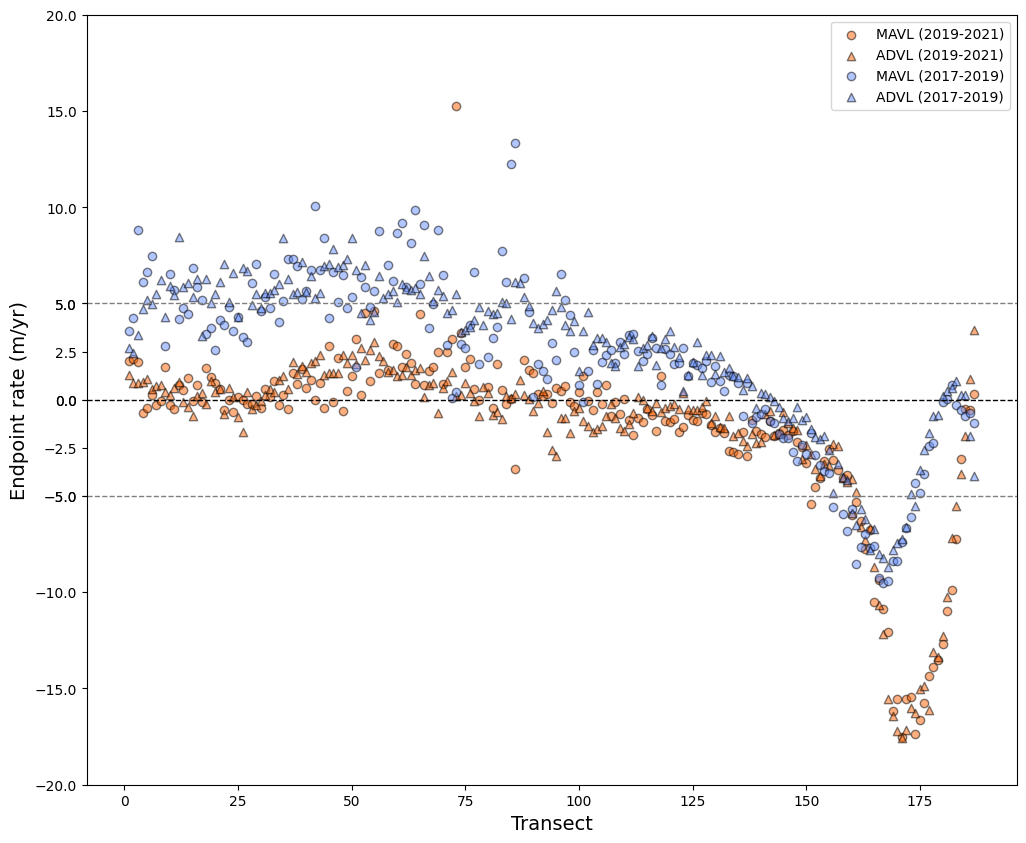

In [27]:
plt.figure(figsize=(12, 10))


plt.scatter(rates['TransectId'], rates['MAVL_2019_2021'], label='MAVL (2019-2021)', marker='o', color=orange,edgecolor='black',alpha=0.5)
plt.scatter(rates['TransectId'], rates['ADVL_2019_2021'], label='ADVL (2019-2021)', marker='^', color=orange,edgecolor='black',alpha=0.5)

plt.scatter(rates['TransectId'], rates['MAVL_2017_2019'], label='MAVL (2017-2019)', marker='o', color=blue,edgecolor='black',alpha=0.5)
plt.scatter(rates['TransectId'], rates['ADVL_2017_2019'], label='ADVL (2017-2019)', marker='^', color=blue,edgecolor='black',alpha=0.5)

#add verticle line at 0 
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.axhline(-5, color='grey', linestyle='--', linewidth=1)
plt.axhline(5, color='grey', linestyle='--', linewidth=1)

plt.xlabel('Transect',size=14)
plt.ylabel('Endpoint rate (m/yr)',size=14)
plt.legend()

# add y-ticks at [-5, -2.5, 0, 2.5, 5] in additional to all existing ticks
plt.yticks(list(plt.yticks()[0]) + [-5, -2.5, 0, 2.5, 5])

save_path = os.path.join(figure_path, "epr_comparison_2years.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

## Step 3: Comparison of Lines

In [ ]:
detected_erosion_lines = gpd.read_file('../data/processed/vegetation_lines/detected_vegetation_lines.shp')

detected_erosion_lines['year'].value_counts().sort_index()

year
2017     6
2019    11
2021    16
Name: count, dtype: int64

In [62]:
distances = pd.read_csv(os.path.join(data_path, f"results/vl_distances_NSM.csv"))
distances.columns = ["TransectId", "2017", "2019", "2021"]

rmse_values = []
mae_values = []
n_values = []
# calculated rmse of each column
for col in distances.columns[1:]:

    n = distances[col].notna().sum()
    n_values.append(n)

    rmse = np.sqrt(np.sum((distances[col] ** 2)) / n)
    rmse_values.append(rmse)

    mae = np.sum(np.abs(distances[col])) / n
    mae_values.append(mae)

# Calculate overall rmse
all_distances = distances.iloc[:, 1:].values.flatten()
# remove NaN values
all_distances = all_distances[~np.isnan(all_distances)]
n = np.count_nonzero(~np.isnan(all_distances))
n_values.append(n)
rmse = np.sqrt(np.sum((all_distances ** 2)) / n)
rmse_values.append(rmse)

mae = np.sum(np.abs(all_distances)) / n
mae_values.append(mae)

# create data frame
results = pd.DataFrame({
    "Year": [2017, 2019, 2021, "Overall"],
    "No. Transects": n_values,
    "No. S2 Scenes": [7,12,14, 7+12+14],
    "RMSE": np.round(rmse_values,1),
    "MAE": np.round(mae_values,1)
})

print(results.to_latex(index=False, float_format="%.1f",))
results

\begin{tabular}{lrrrr}
\toprule
Year & No. Transects & No. S2 Scenes & RMSE & MAE \\
\midrule
2017 & 181 & 7 & 3.7 & 2.8 \\
2019 & 184 & 12 & 2.9 & 2.1 \\
2021 & 186 & 14 & 2.6 & 1.9 \\
Overall & 551 & 33 & 3.1 & 2.2 \\
\bottomrule
\end{tabular}



,Year,No. Transects,No. S2 Scenes,RMSE,MAE
0,2017,181,7,3.7,2.8
1,2019,184,12,2.9,2.1
2,2021,186,14,2.6,1.9
3,Overall,551,33,3.1,2.2


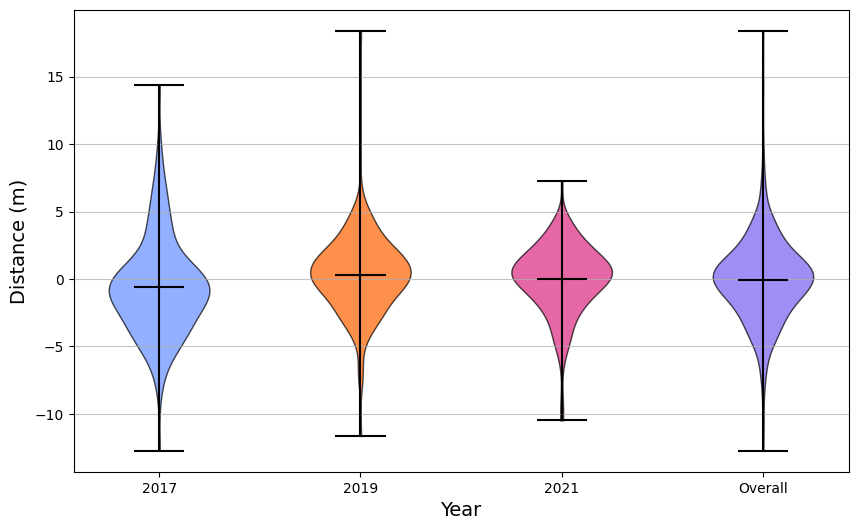

In [37]:
#histogram of distances
import matplotlib.pyplot as plt

# Create violin plots for 2017, 2019, 2021 and overall distances with 4 different colours
plt.figure(figsize=(10, 6))

colors = [blue,orange,red,purple]

parts = plt.violinplot(
    [distances['2017'].dropna(), 
     distances['2019'].dropna(), 
     distances['2021'].dropna(), 
     all_distances],
    showmeans=True
)

# Apply colors to each violin body
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Style mean/min/max lines globally
parts['cmeans'].set_edgecolor('black')

parts['cmaxes'].set_edgecolor('black')
parts['cmins'].set_edgecolor('black')
parts['cbars'].set_edgecolor('black')

plt.xticks([1, 2, 3, 4], ['2017', '2019', '2021', 'Overall'])
plt.xlabel('Year',size=14)
plt.ylabel('Distance (m)',size=14)
plt.grid(axis='y', alpha=0.75)

save_path = os.path.join(figure_path, "distances_violinplot.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

In [50]:
# Outliers 2017
distances['sort'] = np.abs(distances['2017'])
distances = distances.sort_values(by='sort', inplace=False, ascending=False)
outliers = distances['TransectId'][0:5].values
distances.head(5)

,TransectId,2017,2019,2021,sort
84,85,14.38,-1.72,-1.60,14.38
66,67,-12.73,-7.32,-8.73,12.73
59,60,10.28,3.15,0.19,10.28
2,3,9.26,-1.66,-3.70,9.26
60,61,8.41,2.05,1.26,8.41


In [52]:
# Outliers 2019
distances['sort'] = np.abs(distances['2019'])
distances = distances.sort_values(by='sort', inplace=False, ascending=False)
outliers = np.concatenate((outliers, distances['TransectId'][0:5].values))
distances.head(5)


,TransectId,2017,2019,2021,sort
72,73,8.31,18.41,-10.06,18.41
186,187,-6.06,-11.63,-5.42,11.63
85,86,6.98,-7.45,-0.07,7.45
66,67,-12.73,-7.32,-8.73,7.32
185,186,-4.43,-6.72,-3.76,6.72


In [ ]:
# Outliers 2021
distances['sort'] = np.abs(distances['2021'])
distances = distances.sort_values(by='sort', inplace=False, ascending=False)
outliers = np.concatenate((outliers, distances['TransectId'][0:5].values))
distances.head(10)

,TransectId,2017,2019,2021,sort
73,74,-5.64,-4.43,-10.48,10.48
72,73,8.31,18.41,-10.06,10.06
66,67,-12.73,-7.32,-8.73,8.73
45,46,2.06,4.48,7.29,7.29
68,69,5.70,-0.57,-6.55,6.55


In [61]:
outliers = list(set(outliers))
outliers

# Filter transects to only show outliers
transect_path = os.path.join(data_path, "processed/dsas_files/COM_2021_transects_20250908_102419.geojson")
transect = gpd.read_file(transect_path)
transect.rename(columns={"ObjectID": "TransectId"}, inplace=True)
transect = transect[transect['TransectId'].isin(outliers)]

#save to file
transect.to_file(os.path.join(data_path, "processed/dsas_files/distance_outliers.geojson"), driver='GeoJSON')
transect

,TransectId,BaselineID,TransOrder,TransEdit,geometry
2,3,1,3,0,"LINESTRING (722308.052 735266.414, 722308.052 ..."
45,46,1,46,0,"LINESTRING (722898.931 736163.168, 722898.931 ..."
59,60,1,60,0,"LINESTRING (723120.146 736434.341, 723120.146 ..."
60,61,1,61,0,"LINESTRING (723136.525 736453.228, 723136.525 ..."
66,67,1,67,0,"LINESTRING (723235.832 736565.639, 723235.832 ..."
68,69,1,69,0,"LINESTRING (723269.352 736602.738, 723269.352 ..."
72,73,1,73,0,"LINESTRING (723337.437 736675.981, 723337.437 ..."
73,74,1,74,0,"LINESTRING (723354.623 736694.135, 723354.623 ..."
84,85,1,85,0,"LINESTRING (723547.932 736889.698, 723547.932 ..."
85,86,1,86,0,"LINESTRING (723565.878 736907.104, 723565.878 ..."
